> Igor Sorochan DSU-31

## HW: `Model Accuracy Estimation, Overfitting, Regularization`

##### Loading environment

In [307]:
import numpy as np
import pandas as pd 

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, recall_score, precision_recall_curve, precision_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline


from sklearn.decomposition import PCA


import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt  
import seaborn as sns

# np.random.seed(0)

## Prepare

|data frame| used for storing:|
|:---|:---|
|df_raw | untouched input data|
|df | cleaned data|
|df_test|results|
|df_corr|feature correlations|
| X | independent features|
|y (Series) | target labels|
|y_transformed (Series)|encoded target labels|
### EDA
#### Loading the data set (RIO 2016 athletes)

In [308]:
# dataset - https://www.kaggle.com/rio2016/olympic-games
# data = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/datasets_for_t-tests/main/athletes.csv')
df_raw = pd.read_csv('/Users/velo1/SynologyDrive/GIT_syno/Data/athletes_.csv', delimiter = ',')

df_raw.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [309]:
# save data locally
# df_raw.to_csv("/Users/velo1/SynologyDrive/GIT_syno/Data/athletes.csv", index = False) # False - to avoid new index column

In [310]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


##### NaNs

In [311]:
df_raw.isna().sum() # check for missing values

id               0
name             0
nationality      0
sex              0
dob              1
height         330
weight         659
sport            0
gold             0
silver           0
bronze           0
dtype: int64

'height' and 'weight' have NaNs.   
Let's check it closer

In [312]:
df_raw[df_raw['height'].isna() | df_raw['height'].isna() ].head() # check for missing values

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
12,258556239,Abbas Qali,IOA,male,10/11/92,NaN,NaN,aquatics,0,0,0
47,469953606,Abdoullah Bamoussa,ITA,male,6/8/86,NaN,NaN,athletics,0,0,0
50,325809293,Abdul Omar,GHA,male,10/3/93,NaN,NaN,boxing,0,0,0
52,262868423,Abdulaziz Alshatti,IOA,male,10/30/90,NaN,NaN,fencing,0,0,0
56,897549624,Abdullah Hel Baki,BAN,male,8/1/89,NaN,NaN,shooting,0,0,0


The anthropomorphic data is essential for this prediction problem.  
Dropping rows with gaps.

In [313]:
# delete data w/o essential features
df = df_raw[~(df_raw['height'].isna())]
df = df[~(df['weight'].isna())]
# data.info()
df.isna().sum()

id             0
name           0
nationality    0
sex            0
dob            0
height         0
weight         0
sport          0
gold           0
silver         0
bronze         0
dtype: int64

#####  Duplicates

In [314]:
df.duplicated().sum()
# df.drop_duplicates(inplace= True)

0

## Processing
Extracting a `year` of birth from `dob`.

In [315]:
df['dob'] = pd.to_datetime(df['dob'], format='%m/%d/%y').dt.year.astype('int16') # convert to year only as int16
df.sample(3)

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
7761,955910708,Muhammad Akmal Nor Hasrin,MAS,male,1995,1.80,74.0,archery,0,0,0
7688,597431856,Mohammed Aman,ETH,male,1994,1.65,58.0,athletics,0,0,0
3906,443393856,Hamdy Moustafa Elsaid Abdelwahab,EGY,male,1993,1.71,96.0,wrestling,0,0,0


### Deleting features non relevant for predictions.

In [316]:
df.drop(columns=['id','name'], inplace= True)

In [317]:
df.dtypes != 'object'

nationality    False
sex            False
dob             True
height          True
weight          True
sport          False
gold            True
silver          True
bronze          True
dtype: bool

In [318]:
df.dtypes[df.dtypes != 'object']

dob         int16
height    float64
weight    float64
gold        int64
silver      int64
bronze      int64
dtype: object

In [319]:
# select all categorical columns
cat_col = df.select_dtypes(include=['object']).columns
# select all numeric columns
num_col = df.select_dtypes(include=['number']).columns
# num_col = df.dtypes[df.dtypes != 'object']

cat_col, num_col

(Index(['nationality', 'sex', 'sport'], dtype='object'),
 Index(['dob', 'height', 'weight', 'gold', 'silver', 'bronze'], dtype='object'))

Look at categorical features

In [320]:
for col in cat_col:
  # select all unique values in the column and sort them
  print(col.ljust(15),sorted(set(df[col].values)))

nationality     ['AFG', 'ALB', 'ALG', 'AND', 'ANG', 'ANT', 'ARG', 'ARM', 'ARU', 'ASA', 'AUS', 'AUT', 'AZE', 'BAH', 'BAN', 'BAR', 'BDI', 'BEL', 'BEN', 'BER', 'BHU', 'BIH', 'BIZ', 'BLR', 'BOL', 'BOT', 'BRA', 'BRN', 'BRU', 'BUL', 'BUR', 'CAF', 'CAM', 'CAN', 'CAY', 'CGO', 'CHA', 'CHI', 'CHN', 'CIV', 'CMR', 'COD', 'COK', 'COL', 'COM', 'CPV', 'CRC', 'CRO', 'CUB', 'CYP', 'CZE', 'DEN', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'ERI', 'ESA', 'ESP', 'EST', 'ETH', 'FIJ', 'FIN', 'FRA', 'FSM', 'GAB', 'GBR', 'GBS', 'GEO', 'GEQ', 'GER', 'GHA', 'GRE', 'GRN', 'GUA', 'GUI', 'GUM', 'GUY', 'HAI', 'HKG', 'HON', 'HUN', 'INA', 'IND', 'IOA', 'IRI', 'IRL', 'IRQ', 'ISL', 'ISR', 'ISV', 'ITA', 'IVB', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KIR', 'KOR', 'KOS', 'KSA', 'LAO', 'LAT', 'LBA', 'LCA', 'LES', 'LIB', 'LIE', 'LTU', 'LUX', 'MAD', 'MAR', 'MAS', 'MAW', 'MDA', 'MEX', 'MGL', 'MHL', 'MKD', 'MLI', 'MLT', 'MNE', 'MON', 'MOZ', 'MRI', 'MTN', 'MYA', 'NAM', 'NCA', 'NED', 'NEP', 'NGR', 'NIG', 'NOR', 'NRU', 'NZL', 'OMA', 'PA

In [321]:
# filtering categorical columns on whitespaces, dots and underscore symbols
mask = df[cat_col].apply(lambda x: x.str.contains('[\s?._ ]')).any(axis=1)
rows = df[mask]
rows.sample(3)

,nationality,sex,dob,height,weight,sport,gold,silver,bronze
6803,RUS,female,1987,1.76,62.0,table tennis,0,0,0
11100,FRA,female,1985,1.65,57.0,table tennis,0,0,0
828,USA,male,1987,1.88,107.0,rugby sevens,0,0,0


Nothing suspicious. Let's leave it as it is.

### Checking for zeros and negative values, outliers 

In [322]:
px.box(df[num_col], log_y= True)

No negative values

`Height` is given in meters, `weight` in kgs, dob( actually year of birth) is sub 2000 that is real.
* The data needs to be scaled

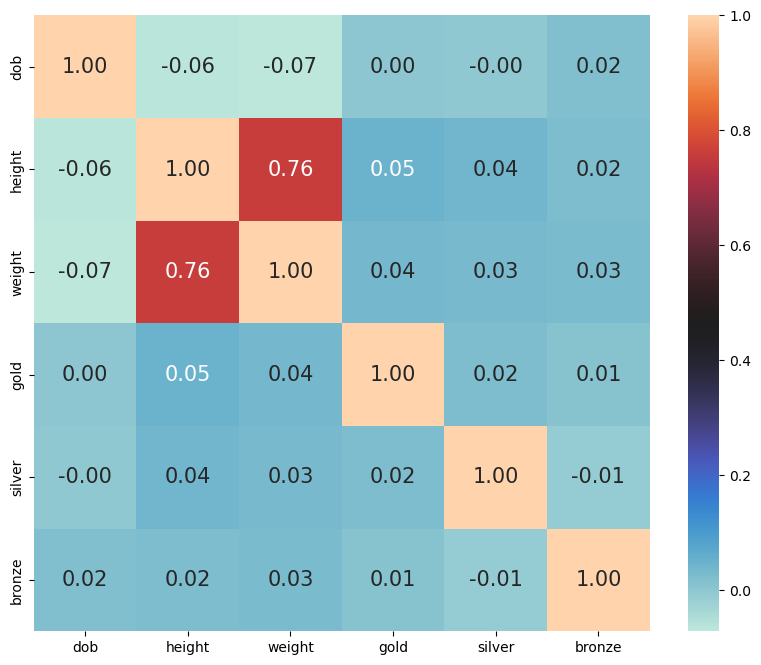

In [323]:
df_corr = df[num_col].corr(numeric_only= True)
# Plotting the heatmap of correlation between numeric features
plt.figure(figsize=(10,8))
sns.heatmap(df_corr, cbar=True, square= True, fmt='.2f', annot=True, annot_kws={'size':15}, cmap='icefire')
plt.show()

There is a high correlation between "weight" and "height".  

This could potentially affect the multicollinearity issue.

## Analyzing
### `Defining target labels and features`

In [324]:
y = df['sex'] # as a pd.Series
X = df.drop('sex', axis= 1)

Figuring out classes imbalance.

In [325]:
px.bar(y.value_counts(), width= 500, title= "Target label imbalance")

The small imbalance is present, but acceptable.
Lets encode the target variable.

##### Encoding target labels

In [326]:
le = LabelEncoder() 
le.fit(y)
le.classes_

array(['female', 'male'], dtype=object)

In [327]:
y_transformed = pd.Series(data= le.transform(y))
y_transformed.value_counts()

1    5862
0    4996
dtype: int64

### Features

[sklearn ohe vs pandas get dummies](https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki)
For machine learning, you almost definitely want to use sklearn.OneHotEncoder.  
For other tasks like simple analyses, you might be able to use pd.get_dummies, which is a bit more convenient.

In [328]:
ohe = OneHotEncoder(sparse=False,handle_unknown="ignore")   # sparse=False - to get np.array instead of sparse matrix

categorical_columns = X.columns[X.dtypes == 'object']
df_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_columns]), columns=ohe.get_feature_names_out(), index=X.index)
df_ohe.head(3)

,nationality_AFG,nationality_ALB,nationality_ALG,nationality_AND,nationality_ANG,nationality_ANT,nationality_ARG,nationality_ARM,nationality_ARU,nationality_ASA,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
num_col = X.select_dtypes(include=['number']).columns
# Concatenate the original dataframe with the one-hot encoded columns
X = pd.concat([X[num_col], df_ohe], axis= 1)

For other tasks like simple analyses, you might be able to use pd.get_dummies, which is a bit more convenient.

In [330]:
# X = pd.get_dummies(X, columns=['sport','nationality'], drop_first=True, sparse= False)

#### Let's try some feature engineering
##### (This experiment with `polynomial features` did not bring any significant results)

In [331]:
# # PolynomialFeatures  - Generate polynomial and interaction features.
# polynomial_features = PolynomialFeatures(degree=2, interaction_only= False) 
# X_poly = polynomial_features.fit_transform(X) 
# X_poly.shape

In [332]:
# X['bmi'] = X['weight'] / (X['height']**2)
# X.drop(columns=['weight'], inplace= True)

In [333]:
X.shape, y_transformed.shape

((10858, 233), (10858,))

### Splitting data

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size= 0.2, random_state= 42)

### Modeling out of the box

In [335]:
log_regr = LogisticRegression()
    
log_regr.fit(X_train, y_train)
print(f'Accuracy :{log_regr.score(X_test, y_test):.5f}') 
print(f'ROC-AUC  :{roc_auc_score(y_test, log_regr.predict(X_test)):.5f}') 
print(f'Recall   :{recall_score(y_test, log_regr.predict(X_test)):.5f}') 
print(f'Precision:{precision_score(y_test, log_regr.predict(X_test)):.5f}') 

Accuracy :0.83195
ROC-AUC  :0.83137
Recall   :0.83754
Precision:0.85261


#### ROC-curve (matplotlib)

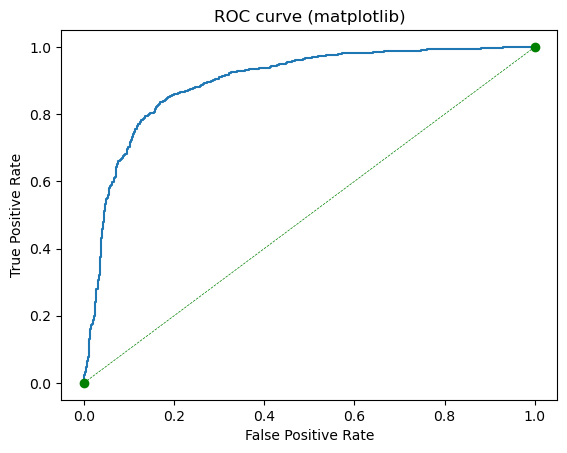

In [369]:
predictions = log_regr.predict_proba(X_test)             # array of probabilities [0,1]
fpr1, tpr2, thres = roc_curve( y_test, predictions[:,1]) # select the second dimension with class 1 probabilities

log_reg_fig = plt.subplot(111)
plt.plot( fpr1, tpr2 )
plt.title("ROC curve (matplotlib)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([[0],[1]], [[0],[1]], 'go', linestyle="--", linewidth = .5) # green with circles
plt.show()

#### ROC-AUC (sklearn engine)

In [337]:
fig = go.Figure()
fig.add_trace(go.Scatter(  x= fpr1,  y= tpr2, mode='lines', fill= 'tozeroy', name= "ROC-AUC (sklearn engine)" , 
                         line=dict(color="grey", width=5))
)
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name="baseline",line=dict(color="Green", width=1)))
fig.update_layout(title= "ROC-AUC curve", xaxis_title="FPR", yaxis_title="TPR", width=900, height=750 )
fig.show()

#### Manual scoring

In [338]:
def conf_matrix(ground_truth, predicted):
    if ground_truth == 0:
        return 'TN' if predicted == 0 else 'FP'
    else:
        return 'TP' if predicted == 1 else 'FN'

In [339]:
df_test =pd.DataFrame({'Predicted':log_regr.predict(X_test), 'GT':y_test})

df_test['conf_matrix'] = df_test.apply(lambda row: conf_matrix(row['GT'], row['Predicted']), axis= 1)
df_test.sample(5)

,Predicted,GT,conf_matrix
7030,0,0,TN
10620,1,1,TP
7910,1,1,TP
9575,0,0,TN
7516,1,1,TP


In [340]:
TP = (df_test['conf_matrix'] == 'TP').sum()
TN = (df_test['conf_matrix'] == 'TN').sum()
FP = (df_test['conf_matrix'] == 'FP').sum()
FN = (df_test['conf_matrix'] == 'FN').sum()
P = (df_test['GT'] == 1).sum()
N = (df_test['GT'] == 0).sum()
CM = np.array([[TP,FN],[FP,TN]])
print('Confusion matrix:\n', CM)

Confusion matrix:
 [[995 193]
 [172 812]]


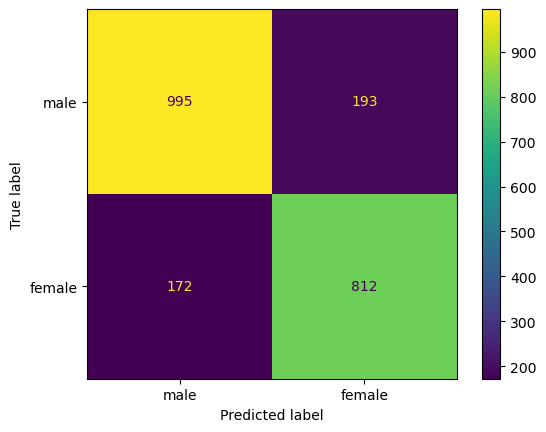

In [341]:
disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                               display_labels=['male','female'])
disp.plot()
plt.show()

<table class="wikitable" style="border:none; background:transparent; text-align:center;" align="center">
<tbody><tr>
<td rowspan="2" style="border:none;">
</td>
<td style="border:none;">
</td>
<td colspan="2" style="background:#bbeeee;"><b>Predicted condition</b>
</td>

</td></tr>
<tr>
<td style="background:#eeeeee;"><a href="/wiki/Statistical_population" title="Statistical population">Total population</a> <br><span style="white-space:nowrap;">= P + N</span>
</td>
<td style="background:#ccffff;"><b>Positive (PP)</b>
</td>
<td style="background:#aadddd;"><b>Negative (PN)</b>
</td></tr>
<tr>
<td rowspan="2" class="nowrap unsortable" style="line-height:99%;vertical-align:middle;padding:.4em .4em .2em;background-position:50% .4em !important;min-width:0.875em;max-width:0.875em;width:0.875em;overflow:hidden;background:#eeeebb;"><div style="vertical-rl=-webkit-writing-mode: vertical-rl; -o-writing-mode: vertical-rl; -ms-writing-mode: tb-rl;writing-mode: tb-rl; writing-mode: vertical-rl; layout-flow: vertical-ideographic;transform:rotate(180deg);display:inline-block;padding-left:1px;text-align:center;"><b>Actual condition</b></div>
</td>
<td style="background:#ffffcc;"><b>Positive (P)</b>
</td>
<td style="background:#ccffcc;"><b><a href="/wiki/True_positive" class="mw-redirect" title="True positive">True positive</a> (TP) <br></b>
</td>
<td style="background:#ffdddd;"><b><a href="/wiki/False_negative" class="mw-redirect" title="False negative">False negative</a> (FN) <br></b>
</td></tr>
<tr>
<td style="background:#ddddaa;"><b>Negative (N)</b>
</td>
<td style="background:#ffcccc;"><b><a href="/wiki/False_positive" class="mw-redirect" title="False positive">False positive</a> (FP) <br></b>
</td>
<td style="background:#bbeebb;"><b><a href="/wiki/True_negative" class="mw-redirect" title="True negative">True negative</a> (TN) <br></b>
</td></tr></tbody></table>

#### Recall (TPR) - probability of effect detection (the ability of the classifier not to make error2 'Miss alarm')

In [342]:
TP/ P, recall_score(y_test, log_regr.predict(X_test))

(0.8375420875420876, 0.8375420875420876)

#### Fall-out (FPR) - probability of false alarm

In [343]:
FP / N

0.17479674796747968

#### Precision   (Positive Predictive Value) - hit rate among positive predictions

In [344]:
TP/(TP+FP), precision_score(y_test, log_regr.predict(X_test))

(0.8526135389888603, 0.8526135389888603)

#### Handmade ROC-curve

In [378]:
def roc(threshold):
    '''
    Calculate FPR, TPR(recall) and precision w.r.t given threshold
    '''
    # model prediction based on threshold  -> pd.Series of False/True
    model_prediction_wrt_threshold = y_test_proba > threshold  
    n = len(y_test)

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for i in y_test.index: # synchronize itereation over y_test.index
        if y_test[i] == 1 and model_prediction_wrt_threshold [i] == 1:
            TP += 1
        elif y_test[i] == 0 and model_prediction_wrt_threshold [i] == 0:
            TN += 1
        elif y_test[i] == 0 and model_prediction_wrt_threshold [i] == 1:
            FP += 1
        elif y_test[i] == 1 and model_prediction_wrt_threshold [i] == 0:
            FN += 1
    
    FPR = FP / (FP + TN)                        # fall-out
    TPR = recall = TP / (TP + FN )              # recall
    PPV = precision = TP / (TP + FP + 1e-10)    # precision
    if threshold == 1:
        precision = 1

    return FPR, recall, precision

In [383]:
# model_prediction -> pd.Series of probabilities of class 1  ,  synchronize itereation over y_test.index
y_test_proba = pd.Series(log_regr.predict_proba(X_test)[:,1], index= y_test.index)

roc_ = []
for thresh in np.linspace(0, 1, 1001):
    res = roc(thresh)          # calculate FPR and TPR w.r.t given threshold
    roc_.append(res)

In [384]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[0,0,1], y=[0,1,1], name='Ideal ROC curve',line=dict(color="blue", width=3)))
fig.add_trace(go.Scatter(  x= fpr1,  y= tpr2, mode='lines', fill= 'tozeroy', name= "ROC-AUC (sklearn)" , 
                         line=dict(color="grey", width=5))
)
# roc_ output: 0-FPR, 1-Recall, 2-Precision

fig.add_trace(go.Scatter(x=[i[0] for i in roc_],y=[i[1] for i in roc_], name= "hm ROC curve",line=dict(color="orange", width=1)) )
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name="baseline",line=dict(color="Green", width=1)))
fig.update_layout(title= "sklearn and handmade ROC-AUC curve", xaxis_title="Fallout  (FPR)", yaxis_title="Recall  (TPR)", width=850, height=750 )
fig.show()

Takeaways:
* Hand made and sklearn ROC curves are almost identical
* ROC curve can be `under` the `baseline` only if our model would be `worse` than a `random` classifier, and its predictions would be completely unreliable.

#### Precision-Recall curve

In [348]:
predictions = log_regr.predict_proba(X_test)             # array of probabilities [0,1]
precision1, recall1, thres = precision_recall_curve( y_test, predictions[:,1]) # select the second dimension with class 1 probabilities

fig = go.Figure()
fig.add_trace(go.Scatter(x=[0,1,1], y=[1,1,0], name='Ideal ROC curve',line=dict(color="blue", width=3)))
fig.add_trace(go.Scatter(  x= recall1,  y= precision1, mode='lines', fill= 'tozeroy', name= "sklearn PR-curve" , 
                         line=dict(color="grey", width=7))
)
# roc_ output: 0-FPR, 1-Recall, 2-Precision
fig.add_trace(go.Scatter(x=[i[1] for i in roc_],y=[i[2] for i in roc_],mode='lines',  name= "hm PR curve",line=dict(color="red", width=1)) )
fig.add_trace(go.Scatter(x=[0,1], y=[1,0], name="baseline",line=dict(color="Green", width=1)))
fig.update_layout(title= "sklearn and handmade PR-AUC curve", xaxis_title="Recall (TPR)", yaxis_title="Precision (PPV)", width=800, height=750 )
fig.show()

##### PR-AUC score

In [349]:
def trapezoidal_rule(x, y):
    '''
    The trapezoidal rule approximates the area under the curve 
    by dividing the region into trapezoids and summing up the areas of those trapezoids. 
    '''
    integral = 0
    n = len(x) - 1
    for i in range(n):
        integral += (x[i+1] - x[i]) * (y[i+1] + y[i]) / 2
    return integral

In [350]:
# precision, recall, f1_score, support = precision_recall_fscore_support(y_test, log_regr.predict(X_test), average= 'binary')
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1_score)
# print("Support:", support)

In [351]:
integral = trapezoidal_rule(np.linspace(0, 1, 1001), [i[2] for i in roc_])

print("The integral of the PR curve is approximately:", integral)
print(f"Mean of Recall values                        : {np.mean([i[2] for i in roc_])}")

The integral of the PR curve is approximately: 0.8081214664584399
Mean of Recall values                        : 0.8080868602611625


##### ROC-AUC score

In [352]:
#                                   roc_ output: 0-FPR, 1-Recall, 2-Precision
hmROC_AUCscore = trapezoidal_rule(np.linspace(0, 1, 1001), [i[1] for i in roc_])

print(f'sklearn ROC-AUC score   :{roc_auc_score(y_test, log_regr.predict(X_test), average="macro")}')
print(f'hand made ROC-AUC score :{hmROC_AUCscore}')

sklearn ROC-AUC score   :0.831372669787304
hand made ROC-AUC score :0.7536195286195289


The difference is big. The area under the ROC-AUC curve is calculated correctly.  
Currently sklearn `average` parameter doesn't have `binary` option as other scores.
I have no idea so far ((

## Model tuning

In [353]:
# this code suppress ConvergenceWarning
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
import sys, os, warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [354]:
pipe_params = {
    'pre_processing': [StandardScaler()],#,  None],
    # 'pca': [PCA(n_components = 'mle', svd_solver = 'full'), PCA(n_components=0.85), None],
}

logit_params = {
    'logit__C': [0.01, 0.1],
    'logit__max_iter': [1e3],
    'logit__penalty': ['l1', 'l2'],
    'logit__solver':['saga', 'lbfgs', 'liblinear']
}

merged = {
    **logit_params, **pipe_params
}


pipe = Pipeline([
    ('pre_processing', StandardScaler()),
    # ('pca', PCA()),
    ('logit', LogisticRegression())
])


grid_s = GridSearchCV(
    pipe, param_grid=merged,
    n_jobs=-1, scoring='roc_auc', cv=5, verbose = 0
).fit(X_train, y_train)

pd.DataFrame(grid_s.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,param_logit__max_iter,param_logit__penalty,param_logit__solver,param_pre_processing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,6.252973,0.720674,0.009044,0.000681,0.1,1000.0,l1,saga,StandardScaler(),"{'logit__C': 0.1, 'logit__max_iter': 1000.0, '...",0.906740,0.905938,0.911745,0.890690,0.903225,0.903667,0.007049,1
8,0.826786,0.235508,0.025071,0.004586,0.1,1000.0,l1,liblinear,StandardScaler(),"{'logit__C': 0.1, 'logit__max_iter': 1000.0, '...",0.906721,0.905982,0.911635,0.890622,0.903158,0.903624,0.007051,2
4,0.460819,0.106794,0.062081,0.018798,0.01,1000.0,l2,lbfgs,StandardScaler(),"{'logit__C': 0.01, 'logit__max_iter': 1000.0, ...",0.903127,0.901434,0.909310,0.887841,0.901264,0.900595,0.007017,3
3,3.263671,0.136693,0.025963,0.001260,0.01,1000.0,l2,saga,StandardScaler(),"{'logit__C': 0.01, 'logit__max_iter': 1000.0, ...",0.903101,0.901455,0.909304,0.887749,0.901243,0.900571,0.007047,4
5,0.859099,0.159043,0.015909,0.001528,0.01,1000.0,l2,liblinear,StandardScaler(),"{'logit__C': 0.01, 'logit__max_iter': 1000.0, ...",0.903043,0.901430,0.909162,0.887895,0.901192,0.900544,0.006953,5


In [355]:
best_params = grid_s.best_params_
best_est = grid_s.best_estimator_

In [356]:
best_params, best_est

({'logit__C': 0.1,
  'logit__max_iter': 1000.0,
  'logit__penalty': 'l1',
  'logit__solver': 'saga',
  'pre_processing': StandardScaler()},
 Pipeline(steps=[('pre_processing', StandardScaler()),
                 ('logit',
                  LogisticRegression(C=0.1, max_iter=1000.0, penalty='l1',
                                     solver='saga'))]))

In [357]:
best_est[1]

LogisticRegression(C=0.1, max_iter=1000.0, penalty='l1', solver='saga')

In [358]:
# {(k.replace("logit__", ""),v) for k,v in best_params.items() if 'logit' in k}
# >>> {('C', 0.1), ('penalty', 'l1'), ('solver', 'saga')}

In [359]:
# load the best params to Log Regr
# lr = best_est[2]

In [360]:
grid_s.best_score_, grid_s.scoring

(0.9036673328033824, 'roc_auc')

This score was the best only over a certain sample and not overall.

In [361]:
final_pipe = Pipeline([
    # ('pre_processing', StandardScaler()),
    # ('logit', best_est[1])
    ('logit', LogisticRegression(max_iter= 1e3))
]).fit(X_train, y_train)

In [362]:
# y_test_pred = LogisticRegression(max_iter= 1e3).fit(X_train,y_train).predict(X_test)
y_test_pred = final_pipe.predict(X_test)
# y_test_pred = grid_s.predict(X_test)
print(f'ROC-AUC  :{roc_auc_score(y_test, y_test_pred):.5f}') 

ROC-AUC  :0.82805


In [363]:
df_test =pd.DataFrame({'Predicted':y_test_pred, 'GT':y_test})
df_test

,Predicted,GT
33,1,1
7234,1,1
8681,0,1
5982,1,1
7065,1,1
...,...,...
8878,1,1
3574,1,1
8515,1,1
603,0,0


### Building a Confusion matrix

In [364]:
confusion_matrix(df_test.GT, df_test.Predicted, labels= [1,0] )

array([[1004,  184],
       [ 186,  798]])

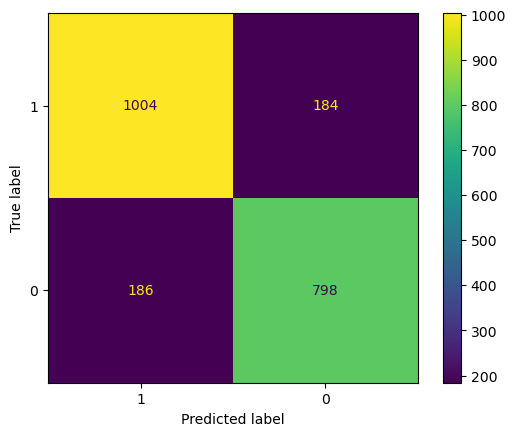

In [365]:
# cm = confusion_matrix(df_test.GT, df_test.Predicted, labels=pipe.classes_ )
cm = confusion_matrix(df_test.GT, df_test.Predicted, labels= [1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels= [1,0])
disp.plot()
plt.show()

By tuning the model we've managed to improve the model from the box `quite a little bit`.

In [366]:
print('Confusion matrix out of the box    :\n', CM)
print('Confusion matrix of the tuned model:\n', cm)

Confusion matrix out of the box    :
 [[995 193]
 [172 812]]
Confusion matrix of the tuned model:
 [[1004  184]
 [ 186  798]]


* The number of errors1 (false male predictions) decreased by 7 and  
* the number of errors2 (missed male predictions) decreased by 7.  

### Main takeaways:
* a. The ROC- and PR- curves look good. Model has a decent precision and recall levels. 


* Fine tuning the model didn't bring any significant improvements. 
Maybe there is no additional hidden patterns in the data itself that model from the box doesn't see.


* b. ROC curve can be `under` the `baseline` only if our model would be `worse` than a `random` classifier, and its predictions would be completely unreliable.